In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timezone
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft
import os
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix as cm

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split as tts

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
# persons = [ 'P' + f"{num:02}" for num in range(1,18)]
# persons

In [3]:
# Get a list of all files in the folder
files = os.listdir("refined_labels")

# Extract the first three letters of the file names and create a list
persons = []

for file in files:
    if(file[0] == 'P'):
        persons.append(file[:3])

In [4]:
print(len(persons))

17


In [5]:
persons

['P09',
 'P10',
 'P07',
 'P03',
 'P14',
 'P04',
 'P13',
 'P17',
 'P01',
 'P16',
 'P12',
 'P05',
 'P15',
 'P02',
 'P06',
 'P11',
 'P08']

In [6]:
test = ['P07','P13','P14','P17']
# test = ['P03','P04','P05','P15']
train = [x for x in persons if x not in test]

# Extracting Features

In [7]:
def extract_features(data, isfft):
    features = []
    for axis in ['ax', 'ay', 'az']:
        features.append(np.mean(data[axis]))
        features.append(np.std(data[axis]))
        features.append(np.mean(np.abs(data[axis] - np.mean(data[axis]))))
        features.append(np.min(data[axis]))
        features.append(np.max(data[axis]))
        features.append(np.max(data[axis]) - np.min(data[axis]))
        features.append(np.median(data[axis]))
        features.append(np.median(np.abs(data[axis] - np.median(data[axis]))))
        Q1 = np.percentile(data[axis], 25)
        Q3 = np.percentile(data[axis], 75)
        features.append(Q3 - Q1)
        
        if(isfft == False):
            features.append(np.sum(data[axis] < 0))
            features.append(np.sum(data[axis] > 0))
            
        features.append(np.sum(data[axis] > np.mean(data[axis])))
        diff = np.diff(np.sign(np.diff(data[axis])))
        peaks = np.where(diff == 2)[0] + 1
        features.append(len(peaks))
        features.append(skew(data[axis]))
        features.append(kurtosis(data[axis]))
        features.append(np.mean(data[axis]**2))
        
        argmin = data[axis].idxmin()
        argmax = data[axis].idxmax()
        diff_argmax_argmin = argmax - argmin
        
        features.append(argmax)
        features.append(argmin)
        features.append(diff_argmax_argmin)
        
    
     # Aggregate 'energy' and 'average resultant acceleration' for all three axes
    avg_resultant_acceleration = np.mean([np.sqrt(np.mean(data[axis]**2)) for axis in ['ax', 'ay', 'az']])
    signal_magnitude_area = np.mean([np.sum(np.abs(data[axis])) for axis in ['ax', 'ay', 'az']])
    
    features.append(avg_resultant_acceleration)
    features.append(signal_magnitude_area)

    return features

# Define a function to compute FFT for a column
def compute_fft(column):
    fft_result = fft(column)
    return np.abs(pd.Series(fft_result))[:250]
                        
def windows():
    Train = pd.DataFrame()
    Test = pd.DataFrame()
    stacked_df  = pd.DataFrame()
    for pn,person in enumerate(persons):
        df = pd.read_csv(f"refined_labels/{person}-imu-right.csv")
        df = df[['ax','ay','az','Label']]
        window_size = 500
        overlap = int(window_size * 0.5)
        windows = [df[i:i+window_size] for i in range(0, len(df) - window_size + 1, overlap)]
        
        feature_columns = []  # List to hold the feature column names

        # Initialize a DataFrame to store the features
        feature_df = pd.DataFrame()

        # Find the number of windows that can be created
        num_windows = len(df) // overlap - 1

        for i in range(num_windows):
            window = windows[i]

            if len(window) < window_size:
                continue  # Skip incomplete windows

            # Find the most common label in this window
            most_common_label = window['Label'].mode().values[0]

            # Extract features for each window
            window_features = extract_features(window, False)

            # Append the label with the highest frequency in this window
            window_features.append(most_common_label)

            feature_df = feature_df.append(pd.Series(window_features), ignore_index=True)

        # Rename the columns for the 50 features
        for axis in ['ax', 'ay', 'az']:
            for stat in ['mean', 'std', 'absdev', 'min', 'max', 'maxmin', 'median', 'medianabsdev', 'iqr', 'negcount', 'poscount', 'abovemean', 'peakcount', 'skew', 'kurtosis', 'energy','argmax','argmin','arg_diff']:
                feature_columns.append(f'{axis}_{stat}')
        
        feature_columns.append('avg_result_accl')
        feature_columns.append('sma')
        # Add label column name
        feature_columns.append('label')

        feature_df.columns = feature_columns
        
#         # Initialize a new list to store DataFrames
#         fft_windows = []
#         # Iterate through the original DataFrames
#         for w in windows:
#             # Create a new DataFrame with the FFT of the first 250 values of 'ax', 'ay', 'az'
#             fft_df = pd.DataFrame()
#             fft_df['ax'] = compute_fft(w['ax'].values)
#             fft_df['ay'] = compute_fft(w['ay'].values)
#             fft_df['az'] = compute_fft(w['az'].values)
#             fft_df['Label'] = pd.Series(w['Label'].values[:250]) # Keep the original labels
            
#             # Append the new DataFrame to the list
#             fft_windows.append(fft_df)
        
#         fft_feature_columns = []  # List to hold the feature column names

#         # Initialize a DataFrame to store the features
#         fft_feature_df = pd.DataFrame()

#         # Find the number of windows that can be created
#         num_windows = len(fft_windows)

#         for i in range(num_windows):
#             window = fft_windows[i]

#             if len(window) < window_size*0.5:
#                 continue  # Skip incomplete windows

#             # Extract features for each window
#             window_features = extract_features(window, True)

#             fft_feature_df = fft_feature_df.append(pd.Series(window_features), ignore_index=True)

#         # Rename the columns for the 50 features
#         for axis in ['ax', 'ay', 'az']:
#             for stat in ['mean', 'std', 'absdev', 'min', 'max', 'maxmin', 'median', 'medianabsdev', 'iqr', 'abovemean', 'peakcount', 'skew', 'kurtosis', 'energy','argmax','argmin','arg_diff']:
#                 fft_feature_columns.append(f'fft_{axis}_{stat}')
        
#         fft_feature_columns.append('fft_avg_result_accl')
#         fft_feature_columns.append('fft_sma')
        
#         fft_feature_df.columns = fft_feature_columns
        
#         stacked_df = pd.concat([fft_feature_df, feature_df], axis=1)
        
#         stacked_df['user'] = person
        
        
        stacked_df = pd.concat([stacked_df, feature_df], axis=0)
        
        # if(person in train):
        #     Train = pd.concat([Train, feature_df], axis=0)
        # else:
        #     Test = pd.concat([Test, feature_df], axis=0)
        
    return stacked_df
                        

In [9]:
data = windows()

In [9]:
# data

In [10]:
X = data.iloc[:,:-1]
y = data.iloc[:, -1]

In [11]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state = 42)

In [12]:
X_train

,ax_mean,ax_std,ax_absdev,ax_min,ax_max,ax_maxmin,ax_median,ax_medianabsdev,ax_iqr,ax_negcount,...,az_abovemean,az_peakcount,az_skew,az_kurtosis,az_energy,az_argmax,az_argmin,az_arg_diff,avg_result_accl,sma
296,-5837.218,1057.081472,841.004200,-8008.0,-3071.0,4937.0,-5985.5,693.0,1354.50,500.0,...,137.0,46.0,1.887735,2.934962,3.081265e+07,74022.0,74258.0,-236.0,8508.724352,4.215826e+06
474,-8904.720,512.033004,431.414240,-9538.0,-7410.0,2128.0,-9126.5,256.0,749.25,500.0,...,181.0,74.0,1.309377,1.077647,6.896837e+06,118567.0,118890.0,-323.0,8287.011655,4.126305e+06
546,2007.584,3439.931840,3041.681984,-5846.0,7589.0,13435.0,2124.5,3222.0,6482.00,172.0,...,272.0,29.0,0.127317,-0.398588,3.646303e+06,136811.0,136723.0,88.0,7365.109690,3.486024e+06
740,-5212.376,6171.693591,5365.163072,-18151.0,4912.0,23063.0,-4190.0,4951.0,10569.25,370.0,...,227.0,38.0,0.066307,-1.404426,3.154484e+08,185368.0,185121.0,247.0,9867.744781,4.005688e+06
235,489.548,1556.575612,1303.800896,-1452.0,4185.0,5637.0,-89.0,713.0,2104.75,283.0,...,252.0,47.0,-0.113826,-0.771645,1.556037e+08,59092.0,59204.0,-112.0,8192.395707,4.014759e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,-6682.794,29.686555,23.194584,-6793.0,-6606.0,187.0,-6681.0,18.0,37.00,500.0,...,236.0,94.0,0.443246,0.516320,2.036299e+08,54570.0,54377.0,193.0,8294.436357,4.147114e+06
480,730.168,935.003972,779.442688,-1311.0,3011.0,4322.0,690.0,668.5,1340.25,112.0,...,280.0,33.0,-0.248328,-0.256006,1.743909e+08,120106.0,120199.0,-93.0,8021.381558,3.955926e+06
416,-3678.038,2034.279119,1783.750608,-7560.0,19.0,7579.0,-3600.5,1877.0,3769.50,499.0,...,262.0,32.0,-0.215583,-0.549570,1.446686e+08,104010.0,104146.0,-136.0,8783.549642,4.295943e+06
37,-6139.692,210.585919,175.442464,-6525.0,-5708.0,817.0,-6148.0,144.5,282.75,500.0,...,238.0,112.0,0.162123,-0.331295,2.093089e+08,9313.0,9454.0,-141.0,8225.611706,4.111939e+06


In [13]:
X_test

,ax_mean,ax_std,ax_absdev,ax_min,ax_max,ax_maxmin,ax_median,ax_medianabsdev,ax_iqr,ax_negcount,...,az_abovemean,az_peakcount,az_skew,az_kurtosis,az_energy,az_argmax,az_argmin,az_arg_diff,avg_result_accl,sma
746,-6196.502,4328.545982,3614.354032,-15462.0,2173.0,17635.0,-6094.5,3542.0,7170.75,458.0,...,220.0,41.0,0.108442,-1.199619,1.041613e+08,186951.0,186572.0,379.0,10223.977264,4.455071e+06
641,-10529.880,10585.078893,9363.232480,-30510.0,4011.0,34521.0,-8447.0,8522.0,19305.25,398.0,...,255.0,33.0,-0.464752,-0.882261,1.316302e+08,160405.0,160304.0,101.0,13083.193279,4.921142e+06
81,3916.110,31.051150,23.481000,3837.0,4046.0,209.0,3912.0,18.5,36.00,0.0,...,251.0,103.0,-0.035881,-0.144982,6.602333e+07,20653.0,20517.0,136.0,8477.969009,4.238948e+06
394,-352.778,2918.391050,2584.913112,-7081.0,4310.0,11391.0,-296.5,2645.0,5162.75,262.0,...,272.0,26.0,-0.322299,-0.791367,5.082404e+07,98999.0,98500.0,499.0,8177.788601,3.925222e+06
57,-6237.578,99.986619,85.389232,-6414.0,-6059.0,355.0,-6220.5,85.0,173.00,500.0,...,307.0,103.0,-0.524239,-1.209504,4.290436e+07,14475.0,14353.0,122.0,8745.212845,4.371790e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,-8672.244,193.235060,150.722048,-9450.0,-7808.0,1642.0,-8676.5,124.0,252.25,500.0,...,260.0,99.0,-0.101068,-0.528058,1.156779e+07,119578.0,119646.0,-68.0,8457.807446,4.226189e+06
624,-8742.464,5336.923878,4558.113984,-20749.0,-560.0,20189.0,-8188.5,4547.5,9100.75,500.0,...,254.0,32.0,-0.401363,-0.793172,1.229033e+08,156151.0,156174.0,-23.0,10320.976874,4.638537e+06
144,-357.188,67.852964,54.933264,-566.0,-204.0,362.0,-355.5,49.0,98.00,500.0,...,246.0,105.0,0.145140,-0.598036,5.186526e+07,36129.0,36442.0,-313.0,7351.729826,3.674742e+06
518,5191.408,2785.224531,2456.260512,-2664.0,9729.0,12393.0,6066.5,2050.5,4881.75,9.0,...,314.0,50.0,-0.844403,-0.454317,5.544061e+07,129775.0,129998.0,-223.0,8903.675876,4.136605e+06


In [14]:
y_train

296    3.0
474    2.0
546    4.0
740    6.0
235    2.0
      ... 
217    2.0
480    4.0
416    3.0
37     1.0
602    5.0
Name: label, Length: 11689, dtype: float64

In [15]:
y_test

746    6.0
641    5.0
81     1.0
394    3.0
57     1.0
      ... 
478    2.0
624    5.0
144    2.0
518    4.0
677    5.0
Name: label, Length: 2923, dtype: float64

# ML Models

In [16]:
# X_train = Train.iloc[:,:-1].values
# y_train = Train.iloc[:,-1].values

In [17]:
# X_test = Test.iloc[:,:-1].values
# y_test = Test.iloc[:,-1].values

In [16]:
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data = scaler.transform(X_train)
X_test_data = scaler.transform(X_test)

In [17]:
# logistic regression model
lr = LogisticRegression()
lr.fit(X_train_data, y_train)
y_pred_lr = lr.predict(X_test_data)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_lr))

Accuracy: 0.857680465275402

 -------------Classification Report-------------

              precision    recall  f1-score   support

         1.0       0.92      0.92      0.92       484
         2.0       0.88      0.82      0.85       553
         3.0       0.79      0.83      0.81       415
         4.0       0.81      0.85      0.83       482
         5.0       0.83      0.82      0.82       450
         6.0       0.90      0.89      0.89       539

    accuracy                           0.86      2923
   macro avg       0.86      0.86      0.86      2923
weighted avg       0.86      0.86      0.86      2923



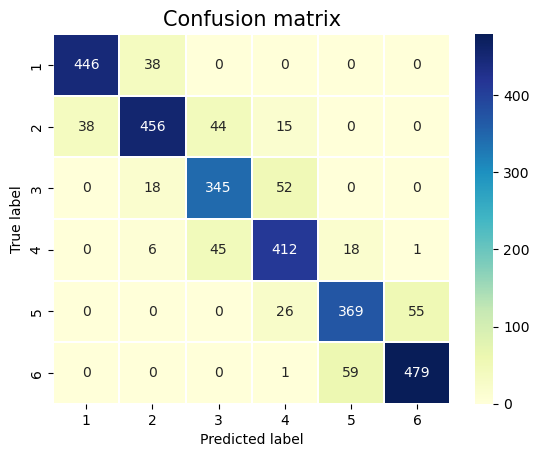

In [18]:
labels = [1,2,3,4,5,6]
confusion_matrix = cm(y_test, y_pred_lr)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt="d", cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Logistic Regreesion

In [19]:
# logistic regression model
knn = KNeighborsClassifier()
knn.fit(X_train_data, y_train)
y_pred_knn = knn.predict(X_test_data)
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_knn))

Accuracy: 0.894970920287376

 -------------Classification Report-------------

              precision    recall  f1-score   support

         1.0       0.91      0.91      0.91       484
         2.0       0.89      0.84      0.86       553
         3.0       0.84      0.93      0.88       415
         4.0       0.88      0.93      0.90       482
         5.0       0.91      0.84      0.87       450
         6.0       0.94      0.92      0.93       539

    accuracy                           0.89      2923
   macro avg       0.89      0.90      0.89      2923
weighted avg       0.90      0.89      0.89      2923



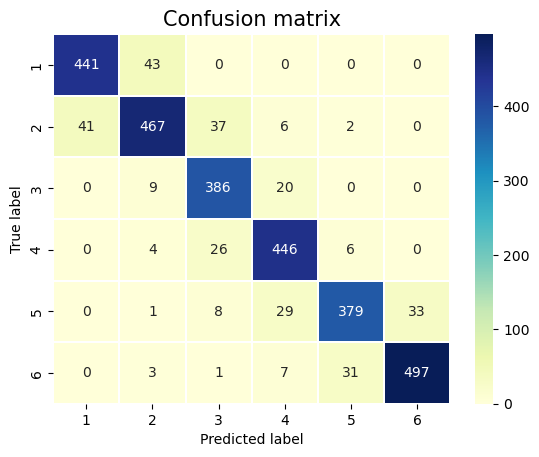

In [20]:
labels = [1,2,3,4,5,6]
confusion_matrix = cm(y_test, y_pred_knn)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt="d", cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Decision Tree

In [21]:
# Decision Tree Classifier model
dt = DecisionTreeClassifier()
dt.fit(X_train_data, y_train)
y_pred_dt = dt.predict(X_test_data)
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_dt))

Accuracy: 0.9490249743414301

 -------------Classification Report-------------

              precision    recall  f1-score   support

         1.0       0.99      0.98      0.98       484
         2.0       0.95      0.95      0.95       553
         3.0       0.92      0.92      0.92       415
         4.0       0.94      0.94      0.94       482
         5.0       0.93      0.94      0.94       450
         6.0       0.96      0.96      0.96       539

    accuracy                           0.95      2923
   macro avg       0.95      0.95      0.95      2923
weighted avg       0.95      0.95      0.95      2923



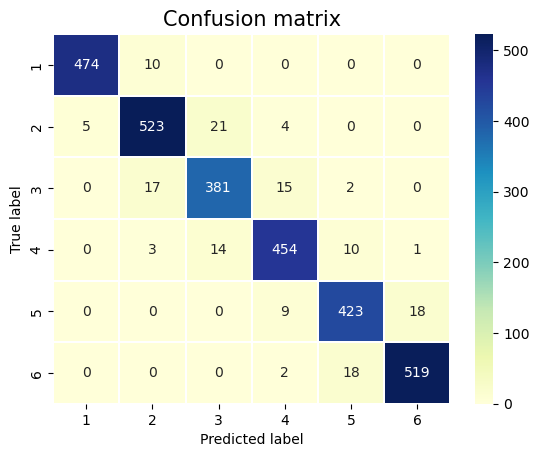

In [22]:
labels = [1,2,3,4,5,6]
confusion_matrix = cm(y_test, y_pred_dt)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt="d", cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Hyperparameter tuning in Decision Tree

In [50]:
# Define a dictionary of hyperparameters and their possible values
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [20, 5, 10]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(dt, param_grid, cv=5)

# Fit the grid search to your data
grid_search.fit(X_train_data, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

In [51]:
# Get the best mean cross-validated score
best_mean_score = grid_search.best_score_

print("Best Mean Cross-Validated Score:", best_mean_score)

Best Mean Cross-Validated Score: 0.7048387096774194


In [52]:
best_params

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 20}

## Random Forest

In [23]:
# Random forest Classifier model
rf = RandomForestClassifier()
rf.fit(X_train_data, y_train)
y_pred_rf = rf.predict(X_test_data)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.9770783441669517

 -------------Classification Report-------------

              precision    recall  f1-score   support

         1.0       0.99      0.98      0.99       484
         2.0       0.98      0.97      0.97       553
         3.0       0.96      0.97      0.97       415
         4.0       0.97      0.98      0.97       482
         5.0       0.98      0.96      0.97       450
         6.0       0.98      0.99      0.99       539

    accuracy                           0.98      2923
   macro avg       0.98      0.98      0.98      2923
weighted avg       0.98      0.98      0.98      2923



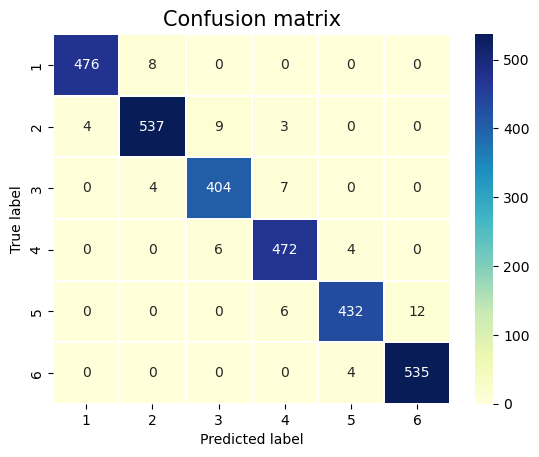

In [24]:
labels = [1,2,3,4,5,6]
confusion_matrix = cm(y_test, y_pred_rf)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt="d", cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Naive Bayes Classifier

In [27]:
# Gaussian Naive Bayes Classifier model
gnb = GaussianNB()
gnb.fit(X_train_data, y_train)
y_pred_gnb = gnb.predict(X_test_data)
print("Accuracy:", accuracy_score(y_test, y_pred_gnb))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_gnb))

Accuracy: 0.6549826187717266

 -------------Classification Report-------------

              precision    recall  f1-score   support

         1.0       0.60      0.98      0.75       528
         2.0       0.63      0.37      0.47       597
         3.0       0.65      0.83      0.73       536
         4.0       0.82      0.59      0.69       608
         5.0       0.62      0.52      0.57       582
         6.0       0.65      0.69      0.67       601

    accuracy                           0.65      3452
   macro avg       0.66      0.66      0.64      3452
weighted avg       0.67      0.65      0.64      3452



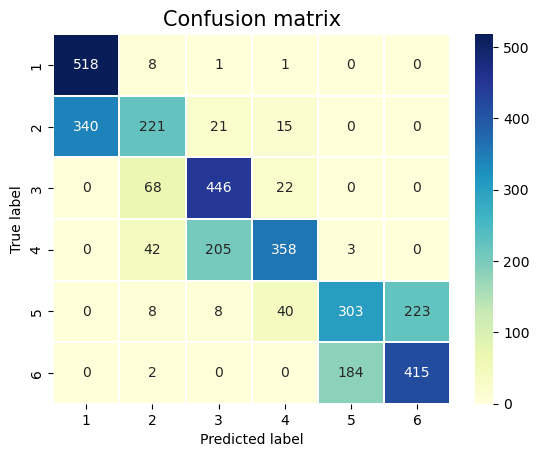

In [28]:
labels = [1,2,3,4,5,6]
confusion_matrix = cm(y_test, y_pred_gnb)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt="d", cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Hyperparameter tuning on Naive Bayes

In [29]:
# Define a dictionary of hyperparameters and their possible values
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(gnb, param_grid, cv=5)

# Fit the grid search to your data
grid_search.fit(X_train_data, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best mean cross-validated score
best_mean_score = grid_search.best_score_

In [30]:
best_params

{'var_smoothing': 1e-09}

In [31]:
best_mean_score

0.5909498207885304

## Support Vector Classification

In [32]:
# SVC Classifier model
svc = SVC()
svc.fit(X_train_data, y_train)
y_pred_svc = lr.predict(X_test_data)
print("Accuracy:", accuracy_score(y_test, y_pred_svc))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_svc))

Accuracy: 0.7250869061413673

 -------------Classification Report-------------

              precision    recall  f1-score   support

         1.0       0.72      0.99      0.83       528
         2.0       0.66      0.64      0.65       597
         3.0       0.60      0.76      0.67       536
         4.0       0.95      0.40      0.57       608
         5.0       0.83      0.70      0.76       582
         6.0       0.75      0.90      0.82       601

    accuracy                           0.73      3452
   macro avg       0.75      0.73      0.72      3452
weighted avg       0.75      0.73      0.71      3452



In [33]:
labels = [1,2,3,4,5,6]
confusion_matrix = cm(y_test, y_pred)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt="d", cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

NameError: name 'y_pred' is not defined